In [48]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import matplotlib.pyplot as plt


In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, color, gray, transform=None, target_transform=None):
        self.color = color
        self.gray = gray
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.color)

    def __getitem__(self, idx):
        image = self.gray[idx]
        label = self.color[idx]
        return image, label

In [25]:
transform_gray = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.5), (0.5))
     ])
transform_color = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
     ])

batch_size = 4

trainset_gray = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_gray)
trainset_color = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                              download=True, transform=transform_color)

testset_gray = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_gray)
testset_color = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_color)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [34]:
color = [sample[0] for sample in trainset_color]
gray = [sample[0] for sample in trainset_gray]

color_test = [sample[0] for sample in testset_color]
gray_test = [sample[0] for sample in testset_gray]

trainset = CustomImageDataset(color, gray)
testset = CustomImageDataset(color_test, gray_test)

In [35]:
trainset[0][0].shape, trainset[0][1].shape

(torch.Size([1, 32, 32]), torch.Size([3, 32, 32]))

In [40]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [47]:
gray_img_batch, color_img_batch = next(iter(trainloader))
gray_img_batch.shape

torch.Size([4, 1, 32, 32])

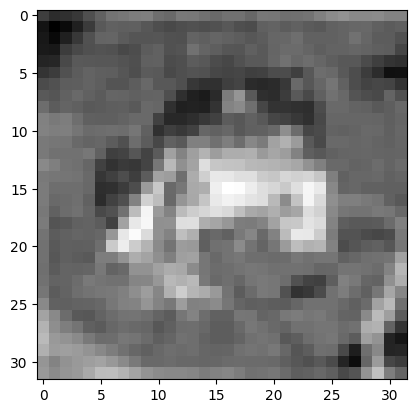

In [ ]:
plt.imshow(trainset[0][0].permute(1, 2, 0), cmap='gray')

In [53]:
trainset[0][0].shape

torch.Size([1, 32, 32])

In [49]:
class Colorizer(nn.Module):
    def __init__(self):
        super(Colorizer, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 3, 1, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.norm1(self.relu(self.conv1(x)))
        x = self.norm2(self.relu(self.conv2(x)))
        x = self.sig(self.conv3(x))
        return x
        

In [51]:
model = Colorizer().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()


#Train and eval loop
epochs = 10
for epoch in range(epochs):
    for i, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Step {i+1}/{len(trainloader)}, Loss: {loss.item():.4f}', end="\r")
    #eval
    with torch.no_grad():
        for i, (x, y) in enumerate(testloader):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            if i % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Step {i+1}/{len(testloader)}, Loss: {loss.item():.4f}', end="\r")      
    

KeyboardInterrupt: 